# 1. GAN

In [20]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 이미지가 저장될 gan_images 폴더 생성
import os
if not os.path.exists("gan_images"):
   os.makedirs("gan_images")

# 생성자 모형
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모형
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# gan 모형
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_8 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_9 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


1/1 [==============================] - 0s 137ms/step
epoch:0  d_loss:0.5418  g_loss:2.0665
1/1 [==============================] - 0s 126ms/step
epoch:1  d_loss:0.3827  g_loss:1.7206
1/1 [==============================] - 0s 76ms/step
epoch:2  d_loss:0.5800  g_loss:1.8313
1/1 [==============================] - 0s 76ms/step
epoch:3  d_loss:0.4814  g_loss:1.3951
1/1 [==============================] - 0s 153ms/step
epoch:4  d_loss:0.5234  g_loss:1.6041
1/1 [==============================] - 0s 236ms/step
epoch:5  d_loss:0.3084  g_loss:2.3952
1/1 [==============================] - 0s 84ms/step
epoch:6  d_loss:0.5418  g_loss:1.7284
1/1 [==============================] - 0s 76ms/step
epoch:7  d_loss:0.5554  g_loss:0.9708
1/1 [==============================] - 0s 77ms/step
epoch:8  d_loss:0.5227  g_loss:0.9353
1/1 [==============================] - 0s 79ms/step
epoch:9  d_loss:0.3971  g_loss:1.1363
1/1 [==============================] - 0s 83ms/step
epoch:10  d_loss:0.2809  g_loss:1.8285
1/1 [

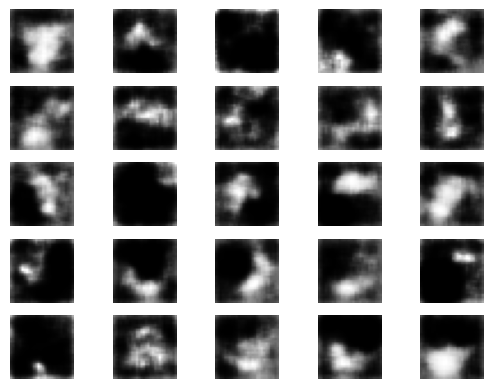

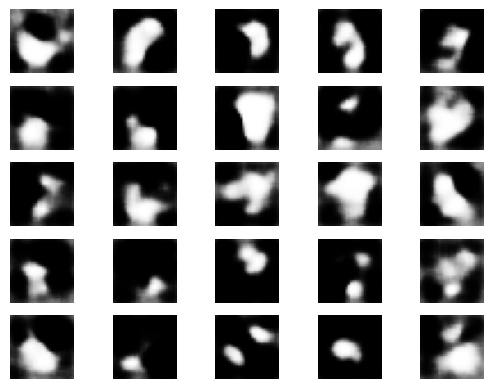

In [10]:
epoch=20
batch_size= 32
saving_interval=10

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5  # -1~1로 스케일링

true = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for i in range(epoch):
          # 실제 데이터를 판별자에 입력
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차 계산
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # saving_interval 간격으로 이미지 저장
          if i % saving_interval == 0:
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)
              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0

              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

# 2. 설명 가능한 딥러닝

In [12]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 701.7 kB/s eta 0:00:00


In [13]:
!pip install opencv-python

In [ ]:
!unzip img.zip

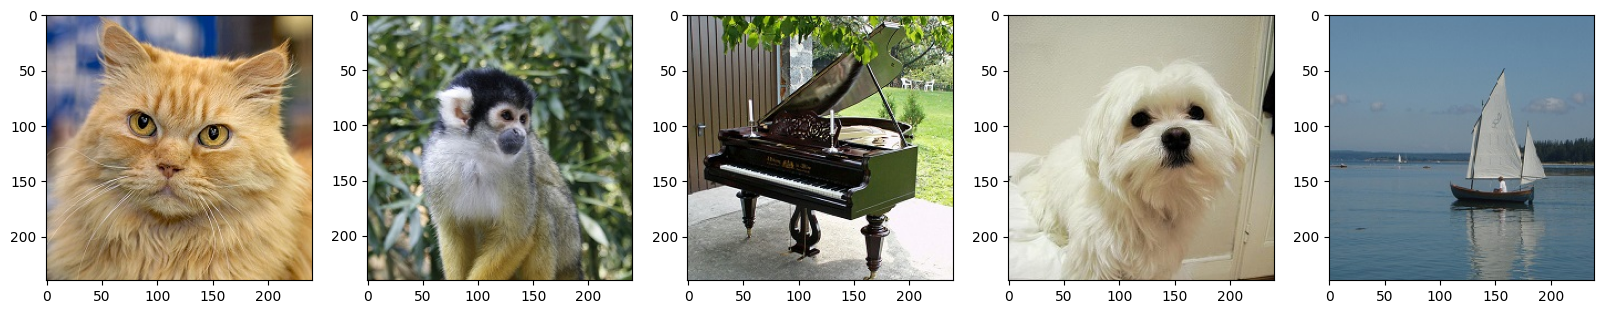

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 원본 이미지 리스트
images_originals = []

# img 폴더에서 이미지 불러오기(glob)
for img_path in glob.glob('img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))

# 원본 이미지 보이기
for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_o)

553467096/553467096 [==============================] - 8s 0us/step


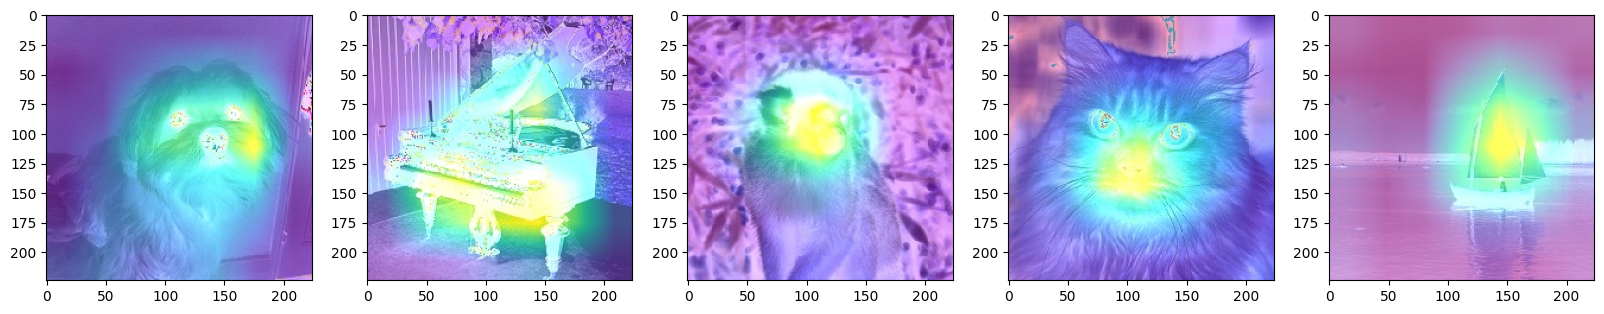

In [16]:
# 사전 학습 딥러닝 모델
model = VGG16(weights="imagenet", include_top=True)

# 원본 이미지 파일 이름 부분, Imagenet에서의 해당 이미지 인덱스
input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]

# 알고리즘 선택
explainer = GradCAM()

# 결과 이미지 담을 빈 리스트
images_cams = []

# 그레이디언트 CAM
for l, i in zip(input_list, imagenet_index):
    img = load_img('img/{}_0.jpg'.format(l), target_size=(224, 224)) # 내부에서 처리될 이미지의 크기 설정
    img = img_to_array(img) # image를 numpy array
    data = ([img], None)
    grid = explainer.explain(data, model, int(i))                 # 그레이디언트 CAM 실행
    explainer.save(grid, ".", 'img/{}_cam.jpg'.format(l)) # 실행 후 저장되는 이름

# 그레이디언트 CAM 알고리즘이 적용된 이미지를 불러오기
plt.figure(figsize=(20,20))

for img_path in glob.glob('img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

2/2 [==============================] - 21s 2s/step


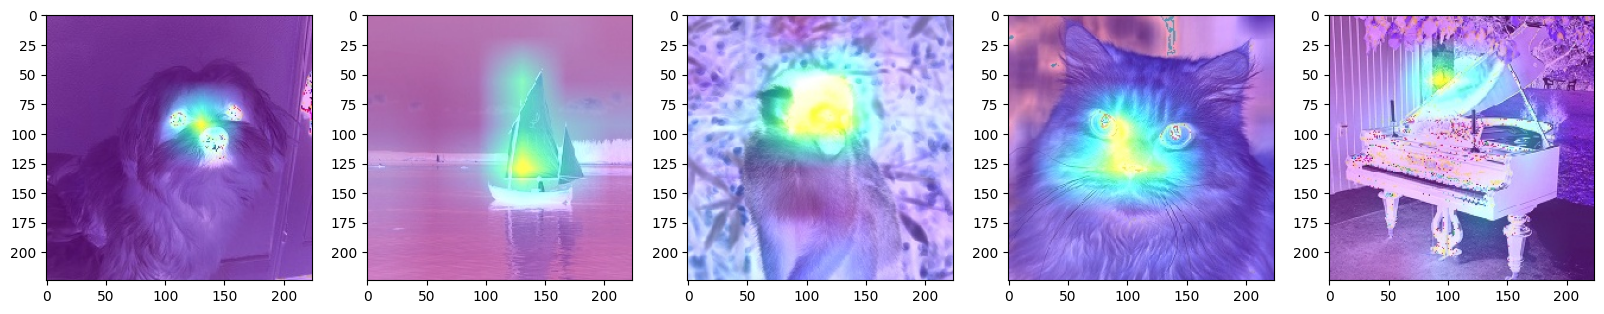

In [17]:
# OcclusionSensitivity
explainer = OcclusionSensitivity()

# 알고리즘 적용 이미지 포함할 빈 리스트
images_occ1s = []

# 패치 사이즈
patch_size = 40

# OcclusionSensitivity 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) #패치 사이즈의 설정 추가.
    explainer.save(grid, ".", 'img/{}_occ1.jpg'.format(l))

# 오클루전 알고리즘이 적용된 이미지 불러오기
plt.figure(figsize=(20,20))

for img_path in glob.glob('img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

5/5 [==============================] - 89s 17s/step


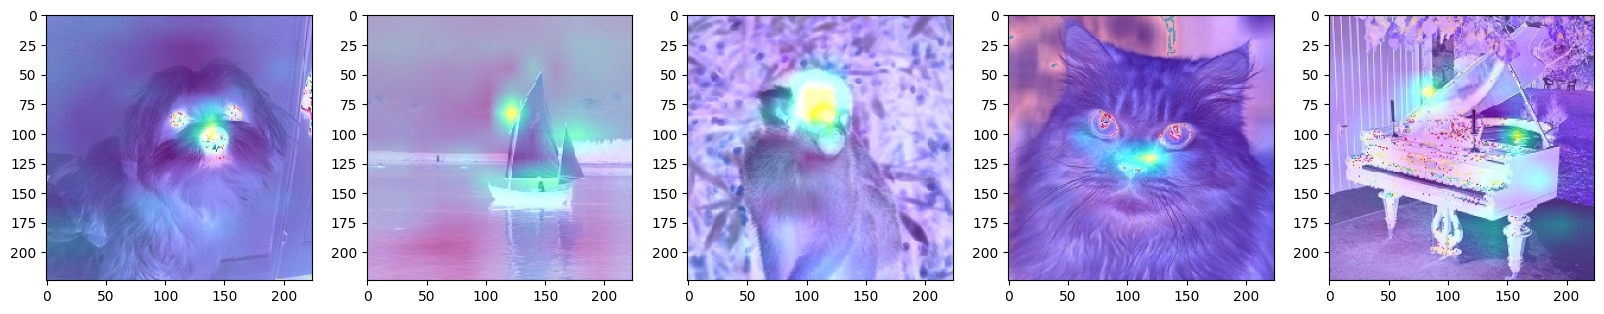

In [18]:
patch_size = 20

images_occ2s = []

for l, i in zip(input_list, imagenet_index):
    img = load_img('img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size)
    explainer.save(grid, ".", 'img/{}_occ2.jpg'.format(l))

for img_path in glob.glob('img/*_occ2.jpg'):
    images_occ2s.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
for i, image in enumerate(images_occ2s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
